In [1793]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import math
from datetime import datetime
import matplotlib.pyplot as plt

In [1794]:
# Dashboard
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
#pd.options.display.max_rows = 4000
sns.set(style="white")
review_rate=0.5    # Assumed share of bookings that were followed up by a user review

In [1795]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [1853]:
# Import dataset 2 months after "data"
data_plus2mth = pd.read_csv("data/2020-03-17/listings.csv.gz")
data_plus2mth.head()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20200317045838,2020-03-17,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,We welcome FAMILIES and cater especially for y...,"We are 5 min walk away from the tram M2, whic...",The apartment will be entirely yours. We are c...,Feel free to ask any questions prior to bookin...,"It’s a non smoking flat, which likes to be tre...",NaN,NaN,https://a0.muscache.com/im/pictures/243355/84a...,NaN,3718,https://www.airbnb.com/users/show/3718,Britta,2008-10-19,"Coledale, New South Wales, Australia",We love to travel ourselves a lot and prefer t...,within a few hours,100%,80%,f,https://a0.muscache.com/im/users/3718/profile_...,https://a0.muscache.com/im/users/3718/profile_...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg,Prenzlauer Berg Südwest,Pankow,Berlin,Berlin,10405,Berlin,"Berlin, Germany",DE,Germany,52.53500,13.41758,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",720.0,$90.00,$520.00,"$1,900.00",$300.00,$100.00,2,$20.00,62,1125,62,62,1125,1125,62.0,1125.0,3 weeks ago,t,0,0,0,140,2020-03-17,145,1,2009-06-20,2019-06-27,93.0,9.0,9.0,9.0,9.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.11
1,3309,https://www.airbnb.com/rooms/3309,20200317045838,2020-03-17,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",The flat is a strictly non-smoking facility! A...,The public transportation is excellent: Severa...,I do have a strictly non-smoker-flat. Keep th...,I'm working as a freelancing photographer. My ...,House-Rules and Information ..............(deu...,NaN,NaN,https://a0.muscache.com/im/pictures/29054294/b...,NaN,4108,https://www.airbnb.com/users/show/4108,Jana,2008-11-07,"Berlin, Berlin, Germany",ENJOY EVERY DAY AS IF IT'S YOUR LAST!!! \r\n\r...,within a day,100%,100%,f,https:

In [1841]:
# Import reviews.csv and convert date to datetime
data_rev = pd.read_csv("data/2020-05-14/reviews.csv")
data_rev.date = data_rev.date.astype('datetime64[D]')
print(data_rev.shape)
#data_rev.head(3)

(722841, 2)


,listing_id,date
0,21974,2017-05-16
1,21974,2017-11-06
2,23197,2011-03-15


# Feature Engineering

The structure of the following sections is set with the aim to derive an estimate for the actual occupancy rate of listings (please see assumptions in notebook 1 | Clean for further notes):
- It is assumed that features at scraping date of "data" will determine occupancy rate for listings the month after (taking into consideration an assumed average lead time of two weeks for a booking)
- Reviews serve as proxy for bookings and will generally be written 1-14 days after finishing a trip
- Additional features are calculated in order to measure changes in price and other features compared to the month before "data"
- Listings that were inactive in any of the considered months (-1 month before data until 2 months after) are removed

## General Features

**Change column content**

In [1797]:
# Reduce cancellation_policy to 4 classes
data.cancellation_policy.replace(["strict_14_with_grace_period", "super_strict_60", "super_strict_30"], ["strict", "super_strict", "super_strict"], inplace=True)

In [1798]:
# Reduce property_type to 6 classes, as per Airbnb classification (see listing creation in pdf)
data.property_type.replace(["Condominium", "Loft", "Vacation home"], "Apartment", inplace=True)
data.property_type.replace(["Aparthotel", "Hostel", "Hotel", "Resort", "Serviced apartment"], "Boutique hotel", inplace=True)
data.property_type.replace(["Casa particular (Cuba)", "Farm stay", "Nature lodge", "Pension (South Korea)"], "Bed and breakfast", inplace=True)
data.property_type.replace(["Bungalow", "Cabin", "Chalet", "Cottage", "Dome house", "Earth house", "Houseboat", "Hut", "Lighthouse", "Tiny house", "Townhouse", "Villa"], "House", inplace=True)
data.property_type.replace(["Guesthouse", "Guest suite"], "Secondary unit", inplace=True)
data.property_type.replace(["Barn", "Boat", "Bus", "Camper/RV", "Campsite", "Castle", "Cave", "Igloo", "Island", "Plane", "Tent", "Tipi", "Train", "Treehouse", "Windmill", "Yurt"], "Unique space", inplace=True)


In [1799]:
# Drop all listings that are not in the above 6 classes
data = data[data.property_type.isin(["Apartment", "Boutique hotel", "Bed and breakfast", "House", "Secondary unit", "Unique space"])]

In [1800]:
# Fill all columns with "0" of "monthly_price" and "weekly_price" with 7x/30x "price"
data["monthly_price"] = np.where(data.monthly_price==0, data.price*30, data.monthly_price)
data["weekly_price"] = np.where(data.weekly_price==0, data.price*7, data.weekly_price)


**Convert binary features to 1/0**

In [1801]:
# Convert t/f to 1/0 for various features
data.host_is_superhost.replace(["t", "f"], [1, 0], inplace=True)
data.host_identity_verified.replace(["t", "f"], [1, 0], inplace=True)
data.is_location_exact.replace(["t", "f"], [1, 0], inplace=True)
data.instant_bookable.replace(["t", "f"], [1, 0], inplace=True)

In [1802]:
# Change availability_365 to 1/0
data.availability_365 = np.where(data.availability_365!=0, 1, 0)

In [1803]:
# Create 1/0 for text descriptions
#data["description_exist"] = [0 for i in range(len(data.index))]
data["description_exist"] = np.where(data.description!="", 1, 0)
data["house_rules_exist"] = np.where(data.house_rules!="", 1, 0)
data["interaction_exist"] = np.where(data.interaction!="", 1, 0)
data["neighborhood_overview_exist"] = np.where(data.neighborhood_overview!="", 1, 0)
data["notes_exist"] = np.where(data.notes!="", 1, 0)
data["space_exist"] = np.where(data.space!="", 1, 0)
data["summary_exist"] = np.where(data.summary!="", 1, 0)
data["transit_exist"] = np.where(data.transit!="", 1, 0)

**Create numerical features**

In [1804]:
# Calculate "price_calc" for one person from "price", "guests_included", "extra_people" and remove listings where "price_calc" ends up being <= 5
data["price_calc"] = data.price - 0.5*data.extra_people*(data.guests_included-1)
data = data[data.price_calc > 5]

In [1805]:
# Calculate "price_extra_people" (price) for additional persons from "price", "guests_included", "extra_people" and "accommodates"
data["price_extra_people"] = (data.extra_people*(data.accommodates-data.guests_included)+(0.5*data.extra_people*(data.guests_included-1)))/(data.accommodates-1)
data.price_extra_people.fillna(0, inplace=True)

In [1806]:
# Calculate existance of "price_extra_fees" from "security_deposit" and "cleaning_fee"
data["price_extra_fees"] = 0 + data.security_deposit + data.cleaning_fee

In [1807]:
# Calculate "descr_detail" as measure for how well the listing is described
data["descr_detail"] = 0 + data.description_exist + data.house_rules_exist + data.interaction_exist + data.neighborhood_overview_exist + data.notes_exist + data.space_exist + data.summary_exist + data.transit_exist

In [1808]:
# Calculate "accommodates_per_room" as feature to de-correlate "accommodates" and "bedrooms"
data["accommodates_per_room"] = data.accommodates/data.bedrooms

In [1809]:
# Calculate "accommodates_per_bed" as feature to de-correlate "accommodates" and "beds" and "bedrooms"
data["accommodates_per_bed"] = data.accommodates/data.beds

In [1810]:
# Calculate "wk_mth_discount" from "monthly_price" and "weekly_price" with "price"
data["wk_mth_discount"] = ((data.price*30-data.monthly_price)/(data.price*30) + (data.price*7-data.weekly_price)/(data.price*7)) / 2

**Create categorical features**

In [1811]:
# Categorize listings by "state" (basic, moderate, luxurious)

In [1812]:
# Create "text_len" as word count from text-based (.split().count)
data["description_len"] = [len(i.split()) for i in data.description]
data["house_rules_len"] = [len(i.split()) for i in data.house_rules]
data["interaction_len"] = [len(i.split()) for i in data.interaction]
data["neighborhood_overview_len"] = [len(i.split()) for i in data.neighborhood_overview]
data["notes_len"] = [len(i.split()) for i in data.notes]
data["space_len"] = [len(i.split()) for i in data.space]
data["summary_len"] = [len(i.split()) for i in data.summary]
data["transit_len"] = [len(i.split()) for i in data.transit]
data["text_len"] = (data.description_len/data.description_len.max() + data.house_rules_len/data.house_rules_len.max() +
                    data.interaction_len/data.interaction_len.max() + data.neighborhood_overview_len/data.neighborhood_overview_len.max() +
                    data.notes_len/data.notes_len.max() + data.space_len/data.space_len.max() + data.summary_len/data.summary_len.max() +
                    data.transit_len/data.transit_len.max()) / 8
data.text_len = data.text_len/data.text_len.max()

**Convert text columns into meaningful information**

In [1813]:
data.description.sample(5)

id
1845815     This 2-room apartment is located in Berlin’s C...
18069548    The flat is suitable for one person or a coupl...
11099159    bright, clean and cosy room in Berlin-Friedric...
23196613    Spacious and bright room, with a balcony, In a...
26734810    Oferuję 3 pokojowe mieszkanie na 1 piętrze z b...
Name: description, dtype: object

**Create log/sqrt from existing features**

Now we will replace certain features, which have relatively high skew (see 2_Clean), with their log

In [1814]:
# Create log "bathrooms_log" for numerical feature "bathrooms"
data["bathrooms_log"] = [math.log(el) for el in data["bathrooms"]]

In [1815]:
# Create sqrt "minimum_nights_sqrt" for numerical feature "minimum_nights"
data["minimum_nights_log"] = [math.sqrt(el) for el in data["minimum_nights"]]

In [1816]:
# Create log "price_extra_fees_sqrt" for numerical feature "price_extra_fees"
data["price_extra_fees_sqrt"] = [math.sqrt(el) for el in data["price_extra_fees"]]

In [1817]:
# Create log "price_log" for numerical feature "price_calc"
data["price_log"] = [math.log(el) for el in data["price_calc"]]

In [1818]:
# Create sqrt "review_scores_rating_sqrt" for numerical feature "review_scores_rating"
review_max = data.review_scores_rating.max()
data["review_scores_rating_sqrt"] = [math.sqrt(review_max-el) for el in data.review_scores_rating]
review_log_max = data.review_scores_rating_sqrt.max()
data["review_scores_rating_sqrt"] = [(review_log_max-el) for el in data.review_scores_rating_sqrt]
#data["review_scores_rating_sqrt"].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [1819]:
# Create log "text_len_sqrt" for numerical feature "text_len"
data["text_len_sqrt"] = [math.sqrt(el) for el in data["text_len"]]

**Opt.: Save of dataset***

In [1820]:
# Reindex and save cleaned and engineered dataset - ONLY IF NEEDED!
#data = data.reindex(sorted(data.columns, reverse=False), axis=1)
#data.to_pickle("saves/data_engineered_2019-12.pkl")

In [1821]:
data.shape

(23702, 81)

## Occupancy

Calculation of **occupancy rate** is inspired by the **San Francisco model**, which is also applied by [Inside AirBnB](http://insideairbnb.com/about.html):

- (**A**) Determine the **average length of stay for Berlin**
- (**B**) Calculate **reviews relevant for considered timeframe (Feb 1-29 2020)**
- (**C**) Determine **active months in timeframe** from price (not relevant if only 1 month)
- (**D**) Estimate **# of bookings in considered timeframe (End Jan-end Feb 2020)** using (**B**)
- (**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/months x 365)

Read more about the core idea behind the calculations of the model [here](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf). Assumptions were adapted for the purpose of this analysis, mainly due to the core idea of considering only the two most recent years.

(**A**) Determine the **average length of stay for Berlin** (assumed 3 days in most cities)

For the purpose of this model, around **3 nights** are assumed as average length of stay in Berlin and used as basis for calculation, unless a higher minimum length is specified
- Back in 2016, [4.6](https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf) has been reported as the average length of stay
- Inside AirBnB uses 3 nights for cities where no current data is available, but uses [6.3 nights](http://insideairbnb.com/berlin/#) for its Berlin visualization

In [1822]:
# Add column to main dataframe for avg length of stay, being either a) 5 nights or b) minimum_nights if higher than 5 or c) avg of min and max if max is 5 or lower
avg_nights = []
for idx in data.index:
    if data.maximum_nights[idx] <=5:
        avg_nights.append((data.maximum_nights[idx]+data.minimum_nights[idx])/2)
    elif data.minimum_nights[idx] >3:
        avg_nights.append(data.minimum_nights[idx])
    else:
        avg_nights.append(3)
data["avg_nights"] = avg_nights

(**B**) Calculate **reviews in considered timeframe**

In [1846]:
data_rev_count = data_rev[(data_rev.date > "2020-01-28") & (data_rev.date < "2020-03-01")]                          # Remove all reviews older than April 2018
data_rev_count = pd.DataFrame(data_rev_count.listing_id.value_counts())
data_rev_count.shape

(7066, 1)

In [1833]:
# Create target dataframe
data_rev_count = data_rev[(data_rev.date > "2020-01-31") & (data_rev.date < "2020-04-01")]                          # Remove all reviews older than April 2018
data_rev_count = pd.DataFrame(data_rev_count.listing_id.value_counts())          # Count reviews per listing and save as table
data_rev_count.rename(columns={"listing_id": "reviews_feb20"}, inplace=True)     # Change column name
data = pd.merge(data, data_rev_count, how="left", left_index=True, right_index=True)    # Add column to main dataset
data.reviews_feb20.fillna(0, inplace=True)

(**C**) Determine **active months and relevant months** from price

In [1825]:
# Count the months where listings were online with a price (not relevant if 1 mth)
#data["active_months"] = data_ts.count(axis=1)
data["active_months"] = 1
relevant_mths = 1

(**D**) Estimate **# of bookings in last two years** by dividing (**B**) through a assumed 50% review rate (i.e. one review corresponds to two bookings)

In [1640]:
# Calculate bookings estimate and replace NaN with 0
data["bookings_est"] = data.reviews_feb20 / review_rate
data.bookings_est.fillna(0, inplace=True)

(**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/23 x 365)

In [1718]:
# Calculate occupancy rate
data["occupancy_rate"] = data.bookings_est * data.avg_nights / (data.active_months/relevant_mths*365)

AttributeError: 'DataFrame' object has no attribute 'bookings_est'

In [1642]:
# Capping occupancy at 100%
occupancy_temp = []
for rate in data.occupancy_rate:
    if rate < 1:
        occupancy_temp.append(rate)
    else:
        occupancy_temp.append(1)
data.occupancy_rate = occupancy_temp

In [1643]:
# Split occupancy into 3 classes (TARGET)
occupancy_class = []
for rate in data.occupancy_rate:
    if rate < 0.25:
        occupancy_class.append(0)
    elif rate < 0.75:
        occupancy_class.append(1)
    else:
        occupancy_class.append(2)
data["occupancy_class"] = occupancy_class

## Seasonality

In [1644]:
# Import listings and create time series dataframe with prices for the time period 04/2018-03/2020 (2 years)

# Save "price" column of data (01/2020) as "data_ts"
data_ts = pd.DataFrame(data.price.copy())

# Rename "price" column to reflect the date "2020-01"
data_ts.rename(columns={"price": "2020-01"}, inplace=True)

# Import other files from 2 year period and add price column (renamed to reflect the date) to "data_ts"
all_files = glob.glob(os.path.join("data/timeseries", "*.csv.gz"))         # save paths of files as list
for f in all_files:                                                        # loop through all paths
    df_temp = pd.read_csv(f, sep=',')                                      # import each file from path and save as temporary dataframe
    df_temp.drop(df_temp.columns.difference(['id','price']), 1, inplace=True)        # keep only columns 'id' and 'price' in temporary dataframe
    df_temp.price = [float(i.strip("$").replace(",","")) for i in df_temp.price]        # convert 'price' into float
    data_ts = pd.merge(data_ts, df_temp, how="left", left_on='id', right_on='id')        # add 'price' from temporary dataframe onto full 'data_ts'
    f_date = f.split('/')[-1].split('_')[0]                                # temporarily save date from file path
    data_ts.rename(columns={"price": f_date}, inplace=True)                # change new 'price' column to reflect the date
    
# Set id as index again and sort columns (newest date to left)
data_ts.set_index('id', inplace=True)
data_ts = data_ts.reindex(sorted(data_ts.columns, reverse=True), axis=1)

# Print new dataframe and its shape
print(data_ts.shape)
data_ts.head()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38,43,61,62,84,85,94) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.


(23702, 24)


,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,60.0,60.0,60.0,NaN,60.0,60.0,60.0,60.0
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,NaN,NaN,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0,NaN,NaN,NaN
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0


**Remove listings with missing price values in considered timeframe**

In [1645]:
# Add a boolean column for whether the listing has had any NaN's in the considered timeframe
data_ts["NaNs"] = [True if any(row.isnull()) else False for idx,row in data_ts.iloc[:,:4].iterrows()]

In [1646]:
# Create a list with all indices that have missing values for price in the considered timeframe
col_rem = list(data_ts[data_ts.NaNs==True].index)

In [1647]:
# Remove listings that have missing values in considered timeframe from "data", "data_ts_rel_mths" and other datasets
data.drop(col_rem, inplace=True)
data_ts.drop(col_rem, inplace=True)

**Add column for price change to "data"**

In [1648]:
# Calculate price changes from month before "data" (in USD)
data_ts["price_chg_2020_01"] = data_ts["2020-01"] - data_ts["2019-12"]

In [1649]:
# Add price change column to "data"
data = pd.merge(data, data_ts.price_chg_2020_01, how="left", left_on='id', right_on='id')

**Fill empty values in data_ts to calculate weighted avg price and seasonal weight (2 yrs from Apr'18 - Mar'20)**

In [1650]:
# Get a weighted average for monthly price

# Calculate monthly average for columns in 'data_ts' and save as list
mth_avg = []
for col in data_ts.columns:
    mth_avg.append(data_ts[col].median())

# Save weighted monthly average as dictionary
mth = ["02_Feb", "01_Jan", "12_Dec", "11_Nov", "10_Oct", "09_Sep", "08_Aug", "07_Jul", "06_Jun", "05_May", "04_Apr", "03_Mar"]


mth_avg_weight = {}
for i in range(11):
    mth_avg_weight.update({mth[i]:(mth_avg[i]*0.7+mth_avg[i+12]*0.3)})
mth_avg_weight.update({mth[11]:mth_avg[11]*0.95})
#print(mth_avg_weight)

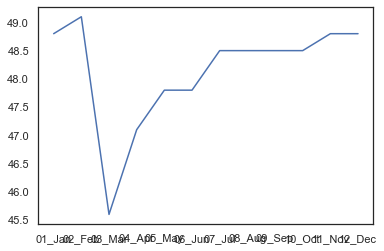

<Figure size 432x288 with 0 Axes>

In [1651]:
# Plot weighted average monthly price over year - IGNORE AS LOGICALLY REFLECTS MAR HIGHEST, APR LOWEST
lists = sorted(mth_avg_weight.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
plt.tight_layout()

In [1652]:
# Fill empty cells with values from next period
data_ts_filled = data_ts.copy()
data_ts_filled.fillna(axis=1, method='ffill')

#for i, col in enumerate(data_ts_filled.columns):
#    if i > 0:
#        data_ts_filled[col] = data_ts_filled[col].fillna(data_ts_filled[data_ts_filled.columns[i-1]])
data_ts_filled.head()


,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,False,0.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,NaN,NaN,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,False,0.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0,NaN,NaN,NaN,False,0.0
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0,False,0.0
9991,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,False,0.0


In [1687]:
# Create column with calculated weighted average price
#weight = 0.4
#price_avg = []
#for 
data_ts_filled["price_avg"] = data_ts_filled.iloc[:,0]*0.5 + data_ts_filled.iloc[:,7]*0.25 + data_ts_filled.iloc[:,15]*0.15 + data_ts_filled.iloc[:,22]*0.10 

In [1654]:
# Create column with calculated price difference between current price and weighted average price
data["price_diff"] = data.price - data.price_avg

In [1655]:
# Create column with calculated price difference as percentage
data["price_diff_perc"] = data.price_diff / data.price

In [1656]:
# Output individual listings from data for review
#data[data.index==42343281]

In [1657]:
# Output individual listings from data_ts for review
data_ts[data_ts.index==36609709]

,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
36609709,150.0,350.0,72.0,77.0,77.0,77.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-5.0


In [1658]:
# Output individual listings from data_ts_filled for review
data_ts_filled[data_ts_filled.index==36609709]

,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
36609709,150.0,350.0,72.0,77.0,77.0,77.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-5.0


In [1690]:
# TEMP: Drop created columns from "data"
data.drop(["price_diff", "price_diff_perc"], inplace=True, axis=1)

**Create columns measuring difference/change (chg) from previous periods**

In [1661]:
#data_raw_2019_12 = data

In [1662]:
# Import data from month before data_clean
#data_raw_2019_12_backup = str.encode(pd.read_csv("saves/data_engineered_2019-12.pkl"))

In [1663]:
# Assign raw import to dataset (in order to always keep a freshly imported raw set) and set id as index
#data_2019_12 = data_raw_2019_12.copy()
#data_2019_12.set_index('id', inplace=True)

In [1664]:
# Keep only relevant listings in datasets from previous time periods
row_keep = list(data.index)
data_2019_12 = data_2019_12[data_2019_12.index.isin(row_keep)]

In [1671]:
data.head(1)

,accommodates,accommodates_per_bed,accommodates_per_room,active_months,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,avg_nights,bathrooms,bathrooms_log,bedrooms,beds,bookings_est,calculated_host_listings_count,cancellation_policy,cleaning_fee,descr_detail,description,description_exist,description_len,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,house_rules_exist,house_rules_len,instant_bookable,interaction,interaction_exist,interaction_len,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,minimum_nights_log,monthly_price,name,neighborhood_overview,neighborhood_overview_exist,neighborhood_overview_len,neighbourhood,notes,notes_exist,notes_len,occupancy_class,occupancy_rate,price,price_avg,price_calc,price_chg_2020_01,price_diff,price_diff_perc,price_extra_fees,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating,review_scores_rating_sqrt,reviews_feb20,room_type,security_deposit,space,space_exist,space_len,summary,summary_exist,summary_len,text_len,text_len_sqrt,transit,transit_exist,transit_len,weekly_price,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,2.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",1,62.0,1.0,0.0,1.0,2.0,0.0,1,strict,100.0,8,This beautiful first floor apartment is situa...,1,175,20.0,2,1,0,"It’s a non smoking flat, which likes to be tre...",1,41,0,Feel free to ask any questions prior to bookin...,1,55,1,52.535,13.41758,1125,62,7.874008,1900.0,Fabulous Flat in great Location,The neighbourhood is famous for its variety of...,1,78,Prenzlauer Berg,We welcome FAMILIES and cater especially for y...,1,109,0,0.0,90.0,90.0,80.0,0.0,0.0,0.0,400.0,20.0,16.666667,4.382027,Apartment,93.0,6.298521,0.0,Entire home/apt,300.0,1st floor (68m2) apartment on Kollwitzplatz/ P...,1,177,This beautiful first floor apartment is situa...,1,35,0.579794,0.761442,"We are 5 min walk away from the tram M2, whic...",1,61,520.0,0.23545,zip_10405


In [1669]:
data_2019_12.head(1)

,accommodates,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bathrooms_log,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,descr_detail,description,description_exist,description_len,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,house_rules_exist,house_rules_len,instant_bookable,interaction,interaction_exist,interaction_len,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,minimum_nights_log,monthly_price,name,neighborhood_overview,neighborhood_overview_exist,neighborhood_overview_len,neighbourhood,notes,notes_exist,notes_len,price,price_calc,price_extra_fees,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating,review_scores_rating_sqrt,room_type,security_deposit,space,space_exist,space_len,summary,summary_exist,summary_len,text_len,text_len_sqrt,transit,transit_exist,transit_len,weekly_price,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",1,1.0,0.0,1.0,2.0,1,strict,100.0,8,This beautiful first floor apartment is situa...,1,175,20.0,2,1,0,"It’s a non smoking flat, which likes to be tre...",1,41,0,Feel free to ask any questions prior to bookin...,1,55,1,52.535,13.41758,1125,62,7.874008,1900.0,Fabulous Flat in great Location,The neighbourhood is famous for its variety of...,1,78,Prenzlauer Berg,We welcome FAMILIES and cater especially for y...,1,109,90.0,80.0,400.0,20.0,16.666667,4.382027,Apartment,93.0,6.298521,Entire home/apt,300.0,1st floor (68m2) apartment on Kollwitzplatz/ P...,1,177,This beautiful first floor apartment is situa...,1,35,0.579794,0.761442,"We are 5 min walk away from the tram M2, whic...",1,61,520.0,0.23545,zip_10405


**Merge columns from previous periods to "data"**

In [1672]:
# Keep only relevant features in datasets from previous time periods (used further below for "calculating difference from previous periods")
data_2019_12 = data_2019_12[["accommodates", "bathrooms", "bedrooms", "beds",
                            "minimum_nights", "host_is_superhost",
                            "host_identity_verified", "instant_bookable",
                            "description_len", "house_rules_len", "interaction_len",
                            "neighborhood_overview_len", "notes_len", "space_len",
                            "summary_len", "transit_len"]]
data_2019_12 = data_2019_12.reindex(sorted(data_2019_12.columns, reverse=False),
                                    axis=1)

In [1673]:
# Rename columns
data_2019_12.rename(columns=lambda x: x+"_2019_12", inplace=True)

In [1675]:
# Add columns from previous dataset(s) to "data"
data = pd.merge(data, data_2019_12, how="left", left_on='id', right_on='id')

In [1693]:
# Remove rows with missing values
data.dropna(axis=0, inplace=True)

In [1695]:
# Revise shape of data
data.shape

(20372, 104)

In [1696]:
# Column for numeric features
data["numeric_chg"] = (data.accommodates-data.accommodates_2019_12) + (data.bathrooms-data.bathrooms_2019_12) + (data.bedrooms-data.bedrooms_2019_12) + (data.beds-data.beds_2019_12)

In [1698]:
# Column for binary features
data["binary_chg"] = (data.host_identity_verified-data.host_identity_verified_2019_12) + (data.host_is_superhost-data.host_is_superhost_2019_12) + (data.instant_bookable-data.instant_bookable_2019_12)

In [1699]:
# Column for minimum night feature
data["minimum_nights_chg"] = data.minimum_nights-data.minimum_nights_2019_12

In [1707]:
# Column for text features
data["text_len_2019_12"] = (data.description_len_2019_12/data.description_len.max() + data.house_rules_len_2019_12/data.house_rules_len.max() +
                    data.interaction_len_2019_12/data.interaction_len.max() + data.neighborhood_overview_len_2019_12/data.neighborhood_overview_len.max() +
                    data.notes_len_2019_12/data.notes_len.max() + data.space_len_2019_12/data.space_len.max() + data.summary_len_2019_12/data.summary_len.max() +
                    data.transit_len_2019_12/data.transit_len.max()) / 8
data.text_len_2019_12 = data.text_len_2019_12/data.text_len.max()    # Compare to "data" in order to keep lengths comparable
data["text_len_chg"] = data.text_len - data.text_len_2019_12

## Final Check, Cleaning and Export

In [1711]:
# Drop further columns
data.drop([
    "accommodates", "active_months", "amenities", "am_coffee_machine",
    "am_cooking_basics", "am_parking", "availability_365", "avg_nights",
    "bathrooms", "beds", "bookings_est", "cleaning_fee", "descr_detail",
    "description", "description_exist", "description_len", "description_exist",
    "extra_people", "guests_included", "host_identity_verified", "house_rules",
    "house_rules_exist", "house_rules_len", "interaction", "interaction_exist",
    "interaction_len", "is_location_exact", "minimum_nights", "monthly_price",
    "name", "neighborhood_overview", "neighborhood_overview_exist",
    "neighborhood_overview_len", "notes", "notes_exist", "notes_len",
    "price", "price_calc", 
#    "price_avg", "price_diff", "price_diff_perc", 
    "price_extra_fees", "review_scores_rating",
    "reviews_feb20", "security_deposit", "space", "space_exist", "space_len",
    "summary", "summary_exist", "summary_len", "text_len", "transit",
    "transit_exist", "transit_len", "weekly_price", 'accommodates_2019_12',
    'bathrooms_2019_12', 'bedrooms_2019_12', 'beds_2019_12',
    'description_len_2019_12', 'host_identity_verified_2019_12',
    'host_is_superhost_2019_12', 'house_rules_len_2019_12',
    'instant_bookable_2019_12', 'interaction_len_2019_12',
    'minimum_nights_2019_12', 'neighborhood_overview_len_2019_12',
    'notes_len_2019_12', 'space_len_2019_12', 'summary_len_2019_12',
    'text_len_2019_12', 'transit_len_2019_12'
],
          inplace=True,
          axis=1)

| **DROPPED FEATURE** | **REASONING** |
| :----- | :----- |
| **am_coffee_machine** | high correlation (>0.3) with >5 other features |
| **am_parking** | high correlation (>0.3) with >5 other features |
| **availability_365** | high correlation (>0.3) with >5 other features |
| **descr_detail** | dropped in favour of **text_len** |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |


In [1715]:
# Review datatypes (data.info()) (post-engineering)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20372 entries, 3176 to 40723686
Data columns (total 39 columns):
accommodates_per_bed              20372 non-null float64
accommodates_per_room             20372 non-null float64
am_balcony                        20372 non-null float64
am_breakfast                      20372 non-null float64
am_child_friendly                 20372 non-null float64
am_elevator                       20372 non-null float64
am_essentials                     20372 non-null float64
am_nature_and_views               20372 non-null float64
am_pets_allowed                   20372 non-null float64
am_private_entrance               20372 non-null float64
am_smoking_allowed                20372 non-null float64
am_tv                             20372 non-null float64
am_white_goods                    20372 non-null float64
bathrooms_log                     20372 non-null float64
bedrooms                          20372 non-null float64
binary_chg                    

In [1713]:
# Sort columns in dataset
data = data.reindex(sorted(data.columns, reverse=False), axis=1)

In [1716]:
# Display engineered dataset
print(data.shape)
data.head(3)

(20372, 39)


,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,bathrooms_log,bedrooms,binary_chg,calculated_host_listings_count,cancellation_policy,host_is_superhost,instant_bookable,latitude,longitude,maximum_nights,minimum_nights_chg,minimum_nights_log,neighbourhood,numeric_chg,occupancy_class,price_chg_2020_01,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating_sqrt,room_type,text_len_chg,text_len_sqrt,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,2.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,strict,0,0,52.53500,13.41758,1125,0.0,7.874008,Prenzlauer Berg,0.0,0,0.0,20.000000,16.666667,4.382027,Apartment,6.298521,Entire home/apt,0.129873,0.761442,0.235450,zip_10405
3309,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,strict,0,0,52.49885,13.34906,35,0.0,2.645751,Schöneberg,0.0,0,0.0,16.733201,0.000000,3.332205,Apartment,5.627647,Private room,0.171669,0.862077,0.197024,zip_10777
6883,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,moderate,0,0,52.51171,13.45477,90,0.0,1.732051,Friedrichshain,0.0,0,0.0,6.244998,0.000000,4.828314,Apartment,7.944272,Entire home/apt,0.088680,0.629000,0.471181,zip_10243


**Export data_engineered**

In [1717]:
# Export dataset for further use in 4_Predictive Modeling
data.to_pickle("saves/data_engineered.pkl")

In [1181]:
# Alternative: Export with to_csv and save dtypes separately
#data.to_csv(r'saves/data_engineered.csv', index = True)
#data.dtypes.to_frame('types').to_csv('saves/types_engineered.csv')